## Load in Libraries

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Project - Part 1

### Import Train Data

In [3]:
x_import = np.load("data/Xtrain_Regression1.npy")
y_import = np.load("data/Ytrain_Regression1.npy")
print(np.shape(x_import))
print(np.shape(y_import))

(100, 10)
(100, 1)


### Divide Train Data into two parts

In [7]:
def split_data(x_import,y_import,train_quantity,total_quantity,method="random"):

    test_quantity = total_quantity - train_quantity

    x_train = np.zeros(shape=(train_quantity, np.shape(x_import)[1]))
    y_train = np.zeros(shape=(train_quantity, np.shape(y_import)[1]))
    x_test = np.zeros(shape=(test_quantity, np.shape(x_import)[1]))
    y_test = np.zeros(shape=(test_quantity, np.shape(y_import)[1]))

    if method == "random":
        random_index = random.sample(range(0, total_quantity), test_quantity)
        train_index, test_index = 0, 0
        for i in range(np.shape(x_import)[0]):
            if i not in random_index:
                x_train[train_index] = x_import[i]
                y_train[train_index] = y_import[i]
                train_index += 1
            elif i in random_index:
                x_test[test_index] = x_import[i]
                y_test[test_index] = y_import[i]
                test_index += 1
        return (x_train,y_train,x_test,y_test)

    # deprecated method, splits the last elements
    if method == "last_elements":
        x_train = x_import[0:-1*test_quantity] 
        x_test = x_import[train_quantity:]
        y_train = y_import[0:-1*test_quantity]
        y_test = y_import[train_quantity:]

        return (x_train,y_train,x_test,y_test)       

xdiv_train,ydiv_train,xdiv_test,ydiv_test = split_data(x_import,y_import,75,np.shape(x_import)[0],method="random")
np.shape(xdiv_train)

(75, 10)

### Create Functions to implement the models

#### Linear Model

In [46]:
def linear_model_func(x, y, method="custom"):

    #add collumn of ones
    col_ones = np.ones((np.shape(x)[0],1))
    X = np.hstack([col_ones,x])

    if method == "custom":

        XT = np.transpose(X) #transpose ones
        XT_X = np.matmul(XT,X) # Find X^t*X
        XT_X_inv = np.linalg.inv(XT_X) # Find inverse
        XT_Y = np.matmul(XT,y) # Find X^t*y
        beta = np.matmul(XT_X_inv,XT_Y) # Find beta

        ## beta = np.linalg.tensorsolve(xt_x,xt_y) #solve for beta the equation: xt_x * beta = xt_y

        SSE = np.linalg.norm(y - np.matmul(X,beta))**2 # Find SSE
        # print("beta =", beta, "\nSSE", SSE)

        return (beta, SSE)

    if method == "auto":

        model_auto = np.linalg.lstsq(X,y,rcond=None)
        beta = model_auto[0]
        SSE = model_auto[1][0]
        print("beta =", beta, "\nSSE", SSE)
        return (beta,SSE)

def test_linear_model(x,beta,y=False):
    col = np.ones((np.shape(x)[0],1))
    X = np.hstack([col,x])
    result = np.matmul(X,beta)

    if type(y) == np.ndarray:
        SSE = np.linalg.norm(y - np.matmul(X,beta))**2
    else:
        SSE = "y not given!"
        print("y not given! SSE not avaiable")

    return (result, SSE)

#### Polynomial Model

#### Ridge Model

#### Lasso Model

### Test Data

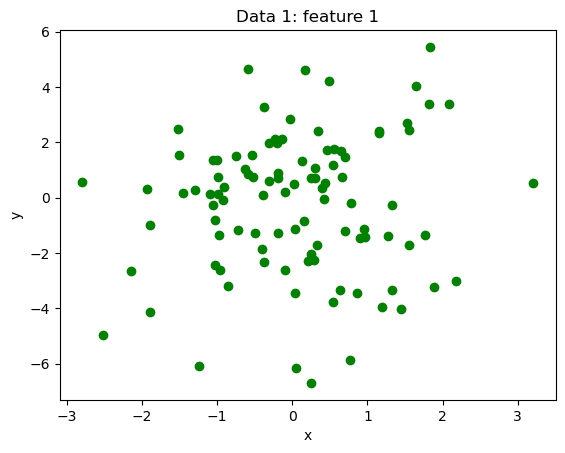

In [29]:
feature = 2
ax = plt.gca()
ax.plot(x_import[:,feature],y_import,"go")
plt.axis('tight')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Data 1: feature "+str(feature-1))
plt.show()

#### Parameters and SSE direct from all data in the linear model

In [30]:
(beta_linear, SSE_linear) = linear_model_func(x_import,y_import, method="custom")
(beta_linear2, SSE_linear2) = linear_model_func(x_import,y_import, method="auto")

beta = [[-1.75055880e-03]
 [ 2.22493631e-02]
 [ 9.55968706e-03]
 [ 7.71569977e-02]
 [ 3.54214621e-01]
 [-7.07947565e-01]
 [ 1.69714631e+00]
 [ 7.65839879e-02]
 [ 1.81078829e+00]
 [-1.23207506e-02]
 [ 1.00971909e-03]] 
SSE 0.9727250665973847
beta = [[-1.75055880e-03]
 [ 2.22493631e-02]
 [ 9.55968706e-03]
 [ 7.71569977e-02]
 [ 3.54214621e-01]
 [-7.07947565e-01]
 [ 1.69714631e+00]
 [ 7.65839879e-02]
 [ 1.81078829e+00]
 [-1.23207506e-02]
 [ 1.00971909e-03]] 
SSE 0.9727250665973846


#### Train model with the 75% test data and Test model with the 25% test data

In [7]:
(xdiv_train,ydiv_train,xdiv_test,ydiv_test) = split_data(x_import,y_import,95,np.shape(x_import)[0],method="random")
(betadiv_linear, SSEdiv_linear) = linear_model(xdiv_train,ydiv_train)
(y_test_result,SSE_test) = test_linear_model(xdiv_test,betadiv_linear,ydiv_test)

# print('Result:',y_test_result)
print('SSE from test =', SSE_test)

beta = [[ 9.86265546e-04]
 [ 2.29455488e-02]
 [ 1.01949049e-02]
 [ 7.51443018e-02]
 [ 3.54061397e-01]
 [-7.08945915e-01]
 [ 1.69660390e+00]
 [ 7.82510034e-02]
 [ 1.80929739e+00]
 [-1.36472854e-02]
 [ 3.95490637e-03]] 
SSE 0.9383341075789275
SSE from test = 0.03725270042562674


### Estimate Final Test Set

In [8]:
x_test_import = np.load("data/Xtest_Regression1.npy")
# Create x_test from x_test_import
x1 = np.ones((np.shape(x_test_import)[0],1))
xfinal_test= np.hstack((x1,x_test_import))
beta_final = np.copy(betadiv_linear)

# Result estimated 
result = np.matmul(xfinal_test,beta_final)
print(np.shape(beta_final))
print(np.shape(xfinal_test))
print(np.shape(result))

(11, 1)
(1000, 11)
(1000, 1)


### Other Models

#### Ridge

In [21]:
from sklearn import linear_model

def ridge_model(x,y,alph):
    col_ones = np.ones((np.shape(x)[0],1))
    X = np.hstack([col_ones,x])
    reg_ridge = linear_model.Ridge(alpha=alph,normalize=False,solver="auto")
    reg_ridge.fit(X,y)
    beta = reg_ridge.coef_[0]
    beta[0] = reg_ridge.intercept_[0]
    SSE = np.linalg.norm(y - np.matmul(X,np.transpose(reg_ridge.coef_)))**2
    return (beta,SSE)

(beta_ridge,SSE_ridge) = ridge_model(x_import,y_import,0.1)
print("beta (ridge) =",beta_ridge)
print("SSE from train (ridge) =",SSE_ridge)

beta (ridge) = [-1.95061341e-03  2.24453830e-02  9.05300558e-03  7.72295153e-02
  3.54010673e-01 -7.06900730e-01  1.69534683e+00  7.67198842e-02
  1.80857364e+00 -1.20247898e-02  1.01648062e-03]
SSE from train (ridge) = 0.9735106673544053


In [ ]:
# Split Data - good random split

(xdiv_train,ydiv_train,xdiv_test,ydiv_test) = split_data(x_import,y_import,80,np.shape(x_import)[0],method="random")

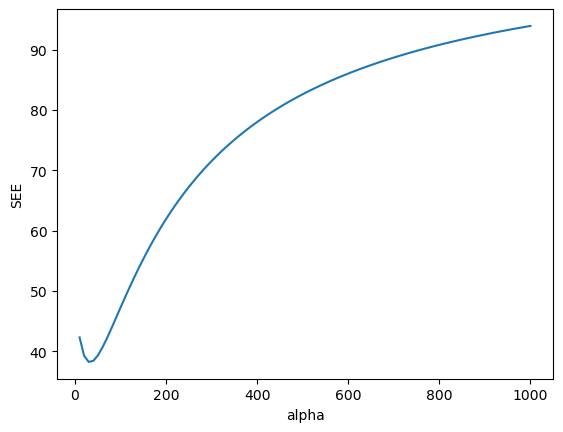

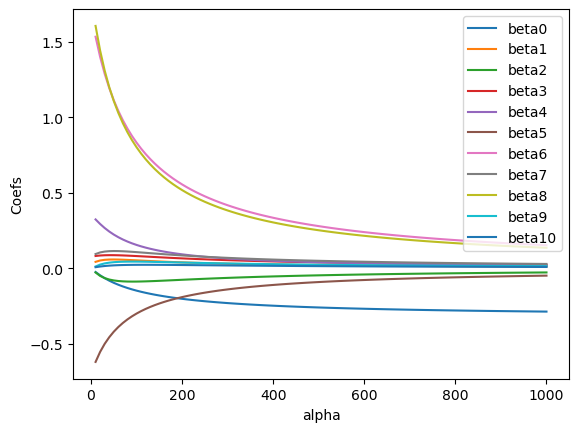

array([30.        , 38.26879008])

In [14]:
alphas = np.linspace(10,1000,100)
SSEs_train = []
SSEs_test = []
coefs = []
y_test_result = []
SSE_test = []

for a in alphas:
    (beta_train,SSE_train) = ridge_model(xdiv_train,ydiv_train,a)
    (y_test_result,SSE_test) = test_linear_model(xdiv_test,beta_train,ydiv_test)
    SSEs_train.append(SSE_train)
    SSEs_test.append(SSE_test)
    coefs.append(beta_train)

ax = plt.gca()
ax.plot(alphas, SSEs_test)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('SEE')
plt.show()

ax2 = plt.gca()
ax2.plot(alphas, coefs)
ax2.legend(["beta0","beta1","beta2","beta3","beta4","beta5","beta6","beta7","beta8","beta9","beta10"])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.show()


#alp_SSE = np.hstack((np.transpose(alphas),np.transpose(SSEs_test)))
alp_SSE = np.transpose(np.vstack((alphas,SSEs_test)))
alp_SSE[np.argmin(alp_SSE,0)[1]]

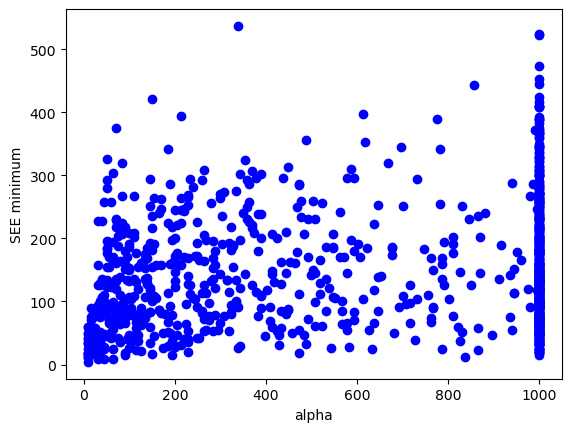

In [408]:
minimum = []

for i in range(1, 1000):
    (xrand_train,yrand_train,xrand_test,yrand_test) = split_data(x_import,y_import,95,np.shape(x_import)[0])
    alphas = np.linspace(10,1000,200)
    SSEs_train = []
    SSEs_test = []
    coefs = []
    y_test_result = []
    SSE_test = []

    for a in alphas:
        (beta_train,SSE_train) = ridge_model(xrand_train,yrand_train,a)
        (y_test_result,SSE_test) = test_linear_model(xrand_test,beta_train,yrand_test)
        SSEs_train.append(SSE_train)
        SSEs_test.append(SSE_test)
        coefs.append(beta_train)

    alp_SSE = np.transpose(np.vstack((alphas,SSEs_test)))
    minimum.append(alp_SSE[np.argmin(alp_SSE,0)[1]])

ax = plt.gca()
ax.plot(np.transpose(minimum)[0],np.transpose(minimum)[1], "bo")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('SEE minimum')
plt.show()

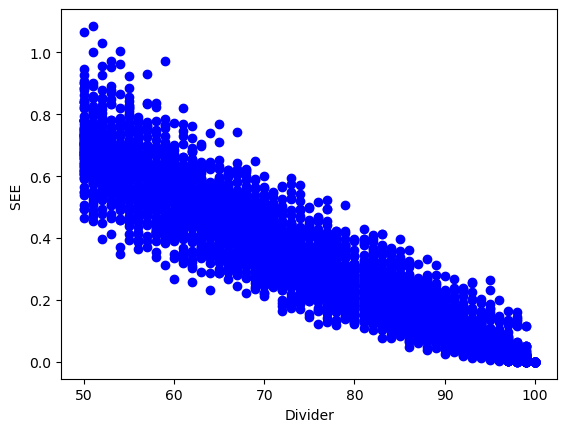

In [65]:
divider = np.linspace(50,100,51)
div_SSE = []

for i in range(1, 100):
    SSEs_train = []
    SSEs_test = []
    coefs = []
    y_test_result = []
    SSE_test = []
    
    for a in divider:
        (xrand_train,yrand_train,xrand_test,yrand_test) = split_data(x_import,y_import,int(a),np.shape(x_import)[0],method="random")

        (beta_train,SSE_train) = linear_model_func(xrand_train,yrand_train, method="custom")
        (y_test_result,SSE_test) = test_linear_model(xrand_test,beta_train,yrand_test)
        SSEs_train.append(SSE_train)
        SSEs_test.append(SSE_test)
        coefs.append(beta_train)

    div_SSE.append(np.transpose(np.vstack((divider,SSEs_test))))

ax = plt.gca()
ax.plot(np.transpose(div_SSE)[0],np.transpose(div_SSE)[1], "bo")
plt.axis('tight')
plt.xlabel('Divider')
plt.ylabel('SEE ')
plt.show()

#### Lasso

beta (lasso) = [-0.22904546  0.         -0.          0.          0.         -0.
  0.          0.          0.          0.          0.        ]
SSE from train (lasso) = 62463.41124978823


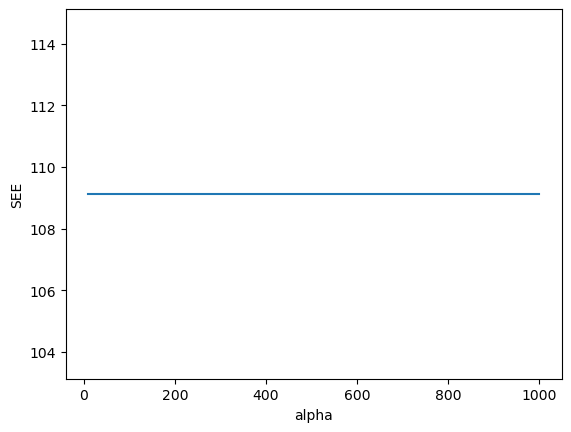

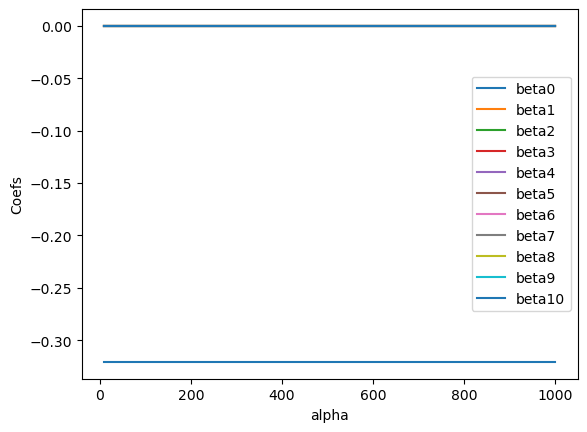

In [12]:
def lasso_model(x,y,alph):
    col_ones = np.ones((np.shape(x)[0],1))
    X = np.hstack([col_ones,x])
    reg_lasso = linear_model.Lasso(alpha=alph,normalize=False)
    reg_lasso.fit(X,y)
    beta = reg_lasso.coef_
    beta[0] = reg_lasso.intercept_[0]
    SSE = np.linalg.norm(y - np.matmul(X,np.transpose(reg_lasso.coef_)))**2
    return (beta,SSE)

(beta_lasso,SSE_lasso) = lasso_model(x_import,y_import,2)
print("beta (lasso) =",beta_lasso)
print("SSE from train (lasso) =",SSE_lasso)

alphas = np.linspace(10,1000,100)
SSEs_train = []
SSEs_test = []
coefs = []
y_test_result = []
SSE_test = []

(xdiv_train,ydiv_train,xdiv_test,ydiv_test) = split_data(x_import,y_import,95,np.shape(x_import)[0],method="random")

for a in alphas:
    (beta_train,SSE_train) = lasso_model(xdiv_train,ydiv_train,a)
    (y_test_result,SSE_test) = test_linear_model(xdiv_test,beta_train,ydiv_test)
    SSEs_train.append(SSE_train)
    SSEs_test.append(SSE_test)
    coefs.append(beta_train)

ax = plt.gca()
ax.plot(alphas, SSEs_test)
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('SEE')
plt.show()

ax2 = plt.gca()
ax2.plot(alphas, coefs)
ax2.legend(["beta0","beta1","beta2","beta3","beta4","beta5","beta6","beta7","beta8","beta9","beta10"])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefs')
plt.show()

In [13]:
from sklearn import decomposition, datasets
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

std_slc = StandardScaler()

pca = decomposition.PCA()

lasso = linear_model.Lasso()

pipe = Pipeline(steps=[("std_slc", std_slc),
                       ("pca", pca),
                       ("lasso", lasso)])

n_components = list(range(1,x_import.shape[1]+1,1))

normalize = [True, False]
selection = ["cyclic", "random"]

parameters = dict(pca__n_components=n_components,
                  lasso__normalize=normalize,
                  lasso__selection=selection)

clf = GridSearchCV(pipe, parameters)
clf.fit(x_import, y_import)

print("Best Number Of Components:", clf.best_estimator_.get_params()["pca__n_components"])
print(clf.best_estimator_.get_params()["lasso"])

CV_Result = cross_val_score(clf, x_import, y_import, cv=11, n_jobs=-1, scoring="r2")
print(CV_Result)
print(CV_Result.mean())
print(CV_Result.std())
(y_test_result,SSE_test) = test_linear_model(x_import,CV_Result,y_import)    
SSE_test
    

Best Number Of Components: 8
Lasso()
[ 0.37974183  0.20657802  0.09560438  0.07809858  0.39385889 -0.07327867
 -0.20611151 -0.22863496  0.30775314  0.05084572  0.16721297]
0.1065153081414926
0.2040109723351131


70880.94946087559